Epoch 1/100
9/9 [==============================] - 1s 33ms/step - loss: 1.4536 - accuracy: 0.5324 - precision: 0.5616 - recall: 0.4815 - val_loss: 0.5341 - val_accuracy: 0.7970 - val_precision: 0.8844 - val_recall: 0.7343
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.6208 - accuracy: 0.7546 - precision: 0.8118 - recall: 0.6991 - val_loss: 0.4720 - val_accuracy: 0.8192 - val_precision: 0.8802 - val_recall: 0.7860
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 0.5659 - accuracy: 0.7713 - precision: 0.8227 - recall: 0.7176 - val_loss: 0.4434 - val_accuracy: 0.8487 - val_precision: 0.8840 - val_recall: 0.8155
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 0.5274 - accuracy: 0.8028 - precision: 0.8367 - recall: 0.7593 - val_loss: 0.4612 - val_accuracy: 0.8376 - val_precision: 0.8776 - val_recall: 0.7934
Epoch 5/100
9/9 [==============================] - 0s 14ms/step - loss: 0.4796 - accuracy: 0.8148 - precision: 0

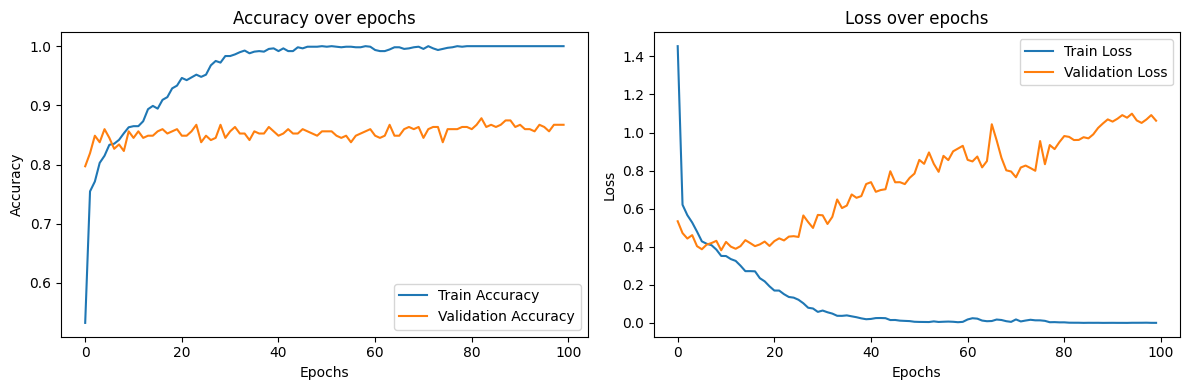

In [10]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.metrics import Precision, Recall
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType, StringType, StructField, StructType

# Initialize Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Audio Classification with CNN") \
    .getOrCreate()

# Define directory containing audio files
base_dir = os.path.expanduser('~/Downloads/data')

# UDF to extract MFCC features
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return mfccs.mean(axis=1).tolist()

extract_features_udf = udf(extract_features, ArrayType(DoubleType()))

# Create schema for the data
schema = StructType([
    StructField("genre", StringType(), False),
    StructField("file_path", StringType(), False),
    StructField("features", ArrayType(DoubleType()), False)
])

# Load and preprocess data
audio_features = []
genres = os.listdir(base_dir)
for genre in genres:
    genre_path = os.path.join(base_dir, genre)
    files = os.listdir(genre_path)
    for file in files:
        file_path = os.path.join(genre_path, file)
        features = extract_features(file_path)
        audio_features.append((genre, file_path, features))

# Randomly shuffle the data
np.random.shuffle(audio_features)

# Create DataFrame
features_df = spark.createDataFrame(audio_features, schema=schema)

# Convert features for TensorFlow
features_labels = features_df.rdd.map(lambda row: (np.array(row.features, dtype=np.float32), row.genre)).collect()

# Split data into training and testing sets
features, labels = zip(*features_labels)
features = np.array(features)
labels = pd.get_dummies(labels).values  # one-hot encoding

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the CNN architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model with additional metrics
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

# Evaluate the model
evaluation_results = model.evaluate(X_test, y_test)
print(f"Loss: {evaluation_results[0]}")
print(f"Accuracy: {evaluation_results[1]}")
print(f"Precision: {evaluation_results[2]}")
print(f"Recall: {evaluation_results[3]}")

# Calculate F1-Score
f1_score = 2 * (evaluation_results[2] * evaluation_results[3]) / (evaluation_results[2] + evaluation_results[3])
print(f"F1 Score: {f1_score}")

# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Stop Spark session
spark.stop()
